In [1]:
import random
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from labellines import labelLines
%matplotlib inline

In [2]:
S = [0, 1, 2, 3, 4, 5, 6]
s0 = 3
terminals = [0, 6]
non_terminals = [s for s in S if s not in terminals]
true_values = [s / 6 for s in non_terminals]

In [3]:
#           0    0     0     0     0    1
#        0 <- 1 <-> 2 <-> 3 <-> 4 <-> 5 -> 6

In [4]:
def gen_episode():
    s = s0
    Ss = [s0]
    As = []
    Rs = []
    while s not in terminals:
        a = random.choice([-1, 1])
        s += a
        r = 1 if s == terminals[1] else 0
        As.append(a)
        Ss.append(s)
        Rs.append(r)
    return Ss, As, Rs

In [5]:
def RMS(a, b):
    from numpy import sqrt, mean, square
    a_ = np.array(a)
    b_ = np.array(b)
    return sqrt(mean(square(a_ - b_)))

In [6]:
def MC(alpha=0.1, episodes=1000):
    discount = 1
    
    V = [(0 if s in terminals else 0.5) for s in S]
    rms = []
    for _ in range(episodes):
        Ss, _, Rs = gen_episode()
        T = len(Rs)
        G = 0
        for t in reversed(range(T)):
            G = discount * G + Rs[t]
            s = Ss[t]
            if s not in Ss[:t]:
                V[s] += alpha * (G - V[s])
        rms.append(RMS(V[1:-1], true_values))
    return V[1:-1], rms

In [7]:
def TD(alpha=0.1, episodes=1000):
    discount = 1
    
    V = [(0 if s in terminals else 0.5) for s in S]
    rms = []
    for _ in range(episodes):
        Ss, _, Rs = gen_episode()
        for s, r, s_ in zip(Ss[:-1], Rs, Ss[1:]):
            V[s] += alpha * (r + discount*V[s_] - V[s])
        rms.append(RMS(V[1:-1], true_values))
    return V[1:-1], rms

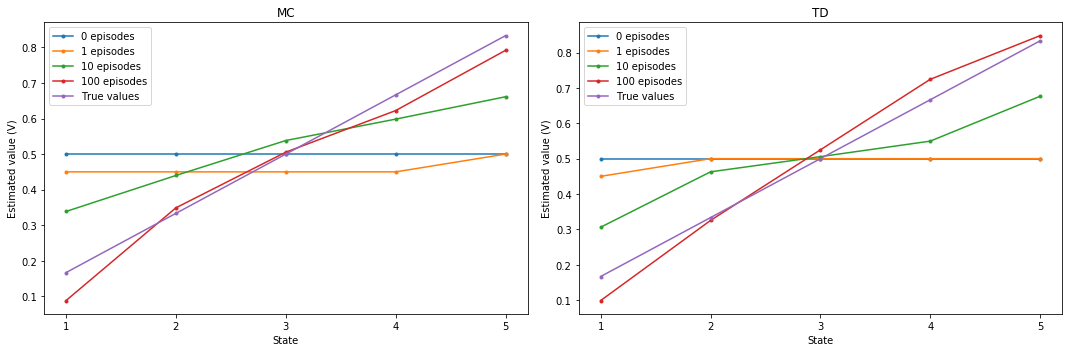

In [8]:
ep_list = [0, 1, 10, 100]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for method, ax in zip(['MC', 'TD'], axes):
    for ep in ep_list:
        random.seed(1126)
        V, _ = eval(method)(episodes=ep)
        ax.plot(non_terminals, V, marker='.', label=f'{ep} episodes')
    ax.plot(non_terminals, true_values, marker='.', label='True values')

    ax.set_xticks(non_terminals)
    ax.set_xlabel('State')
    ax.set_ylabel('Estimated value (V)')
    ax.set_title(method)
    ax.legend()
plt.tight_layout()
plt.show()

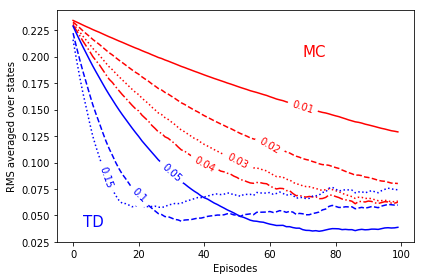

In [9]:
runs = 100
episodes = 100
ls_list = ['solid', 'dashed', 'dotted', 'dashdot']

for i, alpha in enumerate([0.01, 0.02, 0.03, 0.04]):
    random.seed(1126)
    rms = np.mean([MC(alpha, episodes)[1] for _ in range(runs)], axis=0)
    plt.plot(rms, label=f'{alpha}', color='red', ls=ls_list[i])

for i, alpha in enumerate([0.05, 0.10, 0.15]):
    random.seed(1126)
    rms = np.mean([TD(alpha, episodes)[1] for _ in range(runs)], axis=0)
    plt.plot(rms, label=f'{alpha}', color='blue', ls=ls_list[i])

plt.xlabel('Episodes')
plt.ylabel('RMS averaged over states')
labelLines(plt.gca().get_lines(), xvals=[70, 60, 50, 40, 30, 20, 10])
plt.text(70, 0.2, 'MC', color='red', fontsize=15)
plt.text(3, 0.04, 'TD', color='blue', fontsize=15)
plt.tight_layout()
plt.show()